# [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse)
(Прогнозирование биологического ответа)

##### Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  
* Каждая строка представляет молекулу. 
* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. 

Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. 

Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные моделиё
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn import model_selection
from sklearn.model_selection import train_test_split # сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

### Знакомство с данными и их исследование

In [3]:
data = pd.read_csv('data/_train_sem09__1_.zip')
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


In [4]:
TARGET_FEATURE = 'Activity'

Проверяем наличие пропусков

In [5]:
empty_cols = data.isnull().sum()
empty_cols[empty_cols > 0]

Series([], dtype: int64)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


Смотрим на сбалансированность классов:

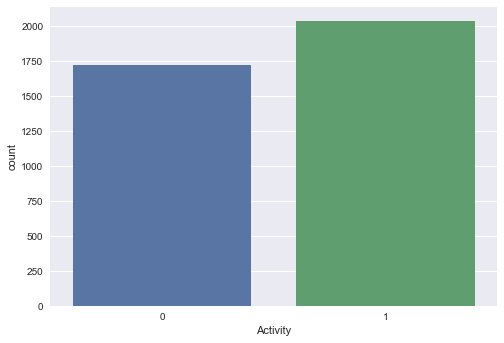

In [7]:
sns.countplot(data=data, x=TARGET_FEATURE);

In [8]:
data[TARGET_FEATURE].value_counts(True) * 100

1    54.22554
0    45.77446
Name: Activity, dtype: float64

Классы немного не сбалансированны. Использую стратификацию при разделении выборки.

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [9]:
X, y = data.drop(columns=TARGET_FEATURE), data[TARGET_FEATURE]

* Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
* Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

#### **Логистическая регрессия**
С гиперпараметрами по умолчанию

In [11]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter=1000)
# solver='sag', # алгоритм оптимизации

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 0.89
f1_score на test наборе: 0.78


### ***Случайный лес***
С гиперпараметрами по умолчанию

In [12]:
# Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
    # n_estimators=500,
    # max_depth=15,
    # criterion='entropy',
    # min_samples_leaf=10,
    
# Обучаем модель
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 1.00
f1_score на test наборе: 0.80


## Подбор гиперпараметров

#### GridSearchCV для алгоритма логистической регрессии

In [13]:
param_grid = {
    'penalty': ['l2', 'none'], # тип регурялизации
    'solver': ['lbfgs', 'saga'], # алгоритм оптимизации
}

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, # генератор случайных чисел
        max_iter=1000 # количество итераций на сходимость
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1'
)

%time grid_search.fit(X_train, y_train)

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

CPU times: total: 16.5 s
Wall time: 1min 19s
f1_score на train наборе: 0.89
f1_score на test наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


In [14]:
# param_grid = [
#               {'penalty': ['l2', 'none'] , # тип регуляризации
#               'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
#                'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
#               {'penalty': ['l1', 'l2'] ,
#               'solver': ['liblinear', 'saga'],
#                'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
# ]


# grid_search = GridSearchCV(
#     estimator=linear_model.LogisticRegression(
#         random_state=42, # генератор случайных чисел
#         max_iter=1000 # количество итераций на сходимость
#     ),
#     param_grid=param_grid,
#     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     n_jobs=-1,
#     scoring='f1'
# )

# %time grid_search.fit(X_train, y_train)

# y_train_pred = grid_search.predict(X_train)
# y_test_pred = grid_search.predict(X_test)

# print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
# print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
# print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

### RandomizedSearchCV

In [15]:
param_distributions = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]
        
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, # генератор случайных чисел
        max_iter=1000 # количество итераций на сходимость
    ),
    param_distributions=param_distributions,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='f1'
)

%time random_search.fit(X_train, y_train)

y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

CPU times: total: 703 ms
Wall time: 1min 32s
f1_score на train наборе: 0.84
f1_score на test наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.34}


Алгоритм случайного поиска показа улучшение метрики на тестовой выборке при существенно меньшем времени потраченном на обучение по сравнение с перебором по сетке

### Hyperopt

In [16]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

In [17]:
# space = [{
#     'penalty': hp.choice('penalty', ['l2', 'none']), # тип регуляризации
#     'solver': hp.choice('solver', ['lbfgs', 'sag']), # алгоритм оптимизации
#     'C': hp.quniform('C', 0.01, 1, 0.025)}, # уровень силы регурялизации
#     {'penalty': hp.choice('penalty', ['l1', 'l2']),
#     'solver': hp.choice('solver', ['liblinear', 'saga']),
#     'C': hp.quniform('C', 0.01, 10, 0.01)}
# ]

space = {
    'penalty': hp.choice('penalty', ['l2', 'none']), # тип регуляризации
    'solver': hp.choice('solver', ['lbfgs', 'sag']), # алгоритм оптимизации
    'C': hp.quniform('C', 0.01, 1, 0.025), # уровень силы регурялизации
    }

In [18]:
# зафксируем random_state
random_state = 42

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # создаем модель
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=10000)
    
    if cv > 0:
        # Создаём объект кросс-валидатора k-fold со стратификацией
        skf = model_selection.StratifiedKFold(n_splits=cv)
        
        # Считаем метрики на кросс-валидации k-fold со стратификацией
        cv_metrics = model_selection.cross_validate(
            estimator=model, # модель
            X=X, # матрица наблюдений X
            y=y, # вектор ответов y
            cv=skf, # кросс-валидатор
            scoring='f1', # метрика
            n_jobs=-1, # использовать все ядра
            return_train_score=False # подсчёт метрики на тренировочных фолдах
        )
        score = np.mean(cv_metrics['test_score'])
    else:
        # обучаем модель
        model.fit(X, y)
        score = metrics.f1_score(y, model.predict(X))

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [19]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=5, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 5/5 [01:10<00:00, 14.08s/trial, best loss: -0.7868475996072775]
Наилучшие значения гиперпараметров {'C': 0.07500000000000001, 'penalty': 0, 'solver': 0}
CPU times: total: 266 ms
Wall time: 1min 10s


In [22]:
best

{'C': 0.07500000000000001, 'penalty': 0, 'solver': 0}

In [23]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(C=0.075, penalty='l2', solver='lbfgs', max_iter=1000)
# solver='sag', # алгоритм оптимизации

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

f1_score на train наборе: 0.85
f1_score на test наборе: 0.78


## <center> Optuna